# US Participation, Employment to Population, Unemployment, and Unfilled Vacancies to Population Rates
In this notebook I look at the total population of the US that works or is capable of working. It's referred to as _Population Level_. It is defined as: "_Persons 16 years of age and older residing in the 50 states and the District of Columbia, who are not inmates of institutions (e.g., penal and mental facilities, homes for the aged), and who are not on active duty in the Armed Forces._"

I then look at the different ratios where the population level is in the denominator:
1. **Participation Rate**: The percentage of the population level that work or are actively looking for work.
2. **Employment/Population Rate**: The percentage of the population level that work.
3. **Unemployment Rate**: The percentage of the population level that are actively looking for work.
4. **Unfilled Vacancies/Population Rate**: The number of unfilled vacancies as percentage of the population level.
and how they've evolved from 1948.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from datetime import date

In [2]:
report_start = date.fromisoformat('1948-01-01')
report_end = date.today()

I use the following dataseries provided by [FRED](https://fred.stlouisfed.org):
* `CNP16OV` &mdash; Population Level, thousands of persons (monthly frequency). Civilian noninstitutional population is defined as persons 16 years of age and older residing in the 50 states and the District of Columbia, who are not inmates of institutions (e.g., penal and mental facilities, homes for the aged), and who are not on active duty in the Armed Forces.
* `CLF16OV` &mdash; Civilian Labor Force Level, seasonally adjusted, thousands of persons (monthly frequency). Members of Civilian noninstitutional population that are 16 years of age and older that are either working or actively looking for work.
* `CE16OV` &mdash; Employment Level, seasonally adjusted, thousands of persons (monthly frequency). Members of Civilian noninstitutional population that are 16 years of age and older that are working.
* `LMJVTTUVUSM647S` &mdash; Total Unfilled Job Vacancies for the United States, seasonally adjusted (monthly frequency).

The rest is derived from these dataseries.

In [3]:
MEAN_LEVEL_OF = 'Mean level of '
PARTICIPATION_RATE = 'Participation Rate'
MEAN_PARTICIPATION_RATE = MEAN_LEVEL_OF + PARTICIPATION_RATE
EMPLOYMENT_POPULATION_RATE = 'Employment/Population Rate'
MEAN_EMPLOYMENT_POPULATION_RATE = MEAN_LEVEL_OF + EMPLOYMENT_POPULATION_RATE
UNEMPLOYMENT_RATE = 'Unemployment Rate'
MEAN_UNEMPLOYMENT_RATE = MEAN_LEVEL_OF + UNEMPLOYMENT_RATE
UNFILLED_VACANCIES_POPULATION_RATE = 'Unfilled Vacancies/Population Rate'
MEAN_UNFILLED_VACANCIES_POPULATION_RATE = MEAN_LEVEL_OF + UNFILLED_VACANCIES_POPULATION_RATE
UNEMPLOYMENT_RATIOS_GRAPH_TITLE = 'US Participation, Employment/Population, Unemployment, and Unfilled Vacancies/Population Rates'

In [4]:
data = web.get_data_fred(['CNP16OV', 'CLF16OV', 'CE16OV', 'LMJVTTUVUSM647S'], report_start, report_end)

data.LMJVTTUVUSM647S /= 1000 # Converting to thousands of persons
data[PARTICIPATION_RATE] = data.CLF16OV / data.CNP16OV
data[EMPLOYMENT_POPULATION_RATE] = data.CE16OV / data.CNP16OV
data[UNEMPLOYMENT_RATE] = (data.CLF16OV - data.CE16OV) / data.CLF16OV
data[UNFILLED_VACANCIES_POPULATION_RATE] = data.LMJVTTUVUSM647S / data.CNP16OV

In [5]:
data.tail()

,CNP16OV,CLF16OV,CE16OV,LMJVTTUVUSM647S,Participation Rate,Employment/Population Rate,Unemployment Rate,Unfilled Vacancies/Population Rate
DATE,,,,,,,,
2022-03-01,263444,164409,158458,11855.0,0.624076,0.601486,0.036196,0.045000
2022-04-01,263559,164046,158105,11681.0,0.622426,0.599885,0.036215,0.044320
2022-05-01,263679,164376,158426,11254.0,0.623394,0.600829,0.036197,0.042681
2022-06-01,263835,164023,158111,NaN,0.621688,0.599280,0.036044,NaN
2022-07-01,264012,163960,158290,NaN,0.621032,0.599556,0.034582,NaN


### Visualizing the data
Looking at the last datapoints, one can see that while unemployment rate has declined to the pre-COVID levels, two other important indicators haven't yet recovered to the pre-pandemic levels:
1. The participation rate (the number of people that work or are actively looking for work as percentage of the population level) is at 62.10% now while it was at 63.39% in Feb 2020.
2. The unfilled vacancies to population rate (the number of unfilled vacancies as percentage of the population level) is at 4.3% while it was at 2.7% in Feb 2020.

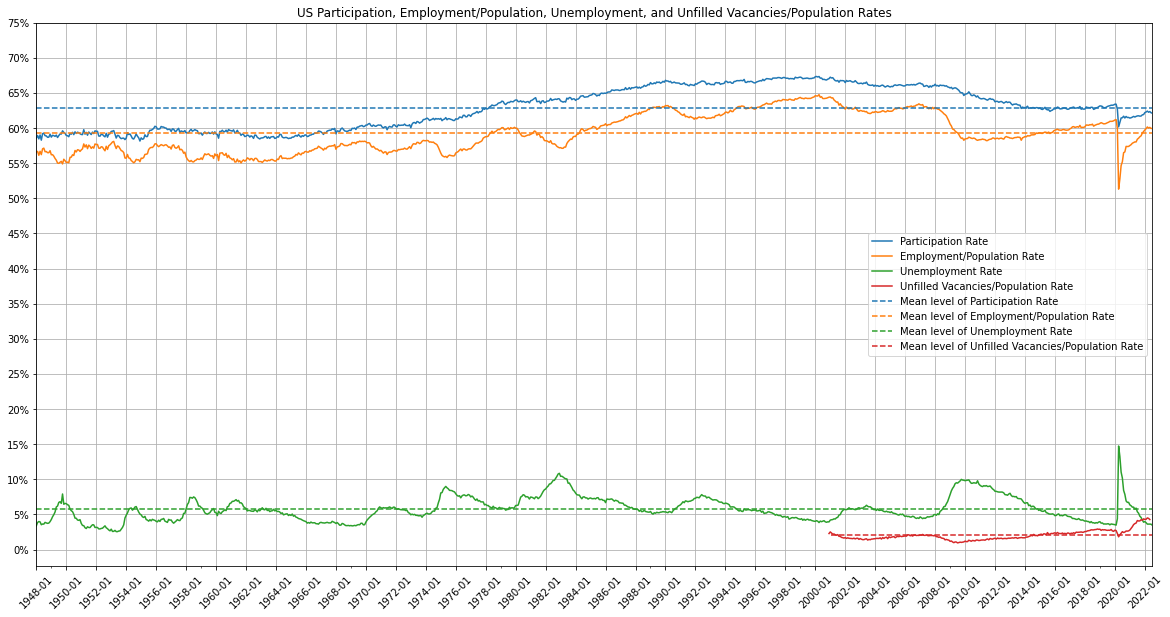

In [6]:
ax = data.iloc[:,4:].plot(figsize=(20,10), grid=True, title=UNEMPLOYMENT_RATIOS_GRAPH_TITLE,
                          xticks=data.index[::24], xlabel='', rot=45, yticks=np.arange(0, .8, .05))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=data.iloc[:,4].mean(), ls='--', c='#1f77b4', label=MEAN_PARTICIPATION_RATE)
ax.axhline(y=data.iloc[:,5].mean(), ls='--', c='#ff7f0e', label=MEAN_EMPLOYMENT_POPULATION_RATE)
ax.axhline(y=data.iloc[:,6].mean(), ls='--', c='#2ca02c', label=MEAN_UNEMPLOYMENT_RATE)
non_nan_to_total_len = data.iloc[:,7].count() / len(data.iloc[:,7])
ax.axhline(y=data.iloc[:,7].mean(), xmin=1-non_nan_to_total_len, ls='--', c='#d62728',
           label=MEAN_UNFILLED_VACANCIES_POPULATION_RATE)
ax.legend()
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), data.index[::24])))

### Zooming in on 2001 and later

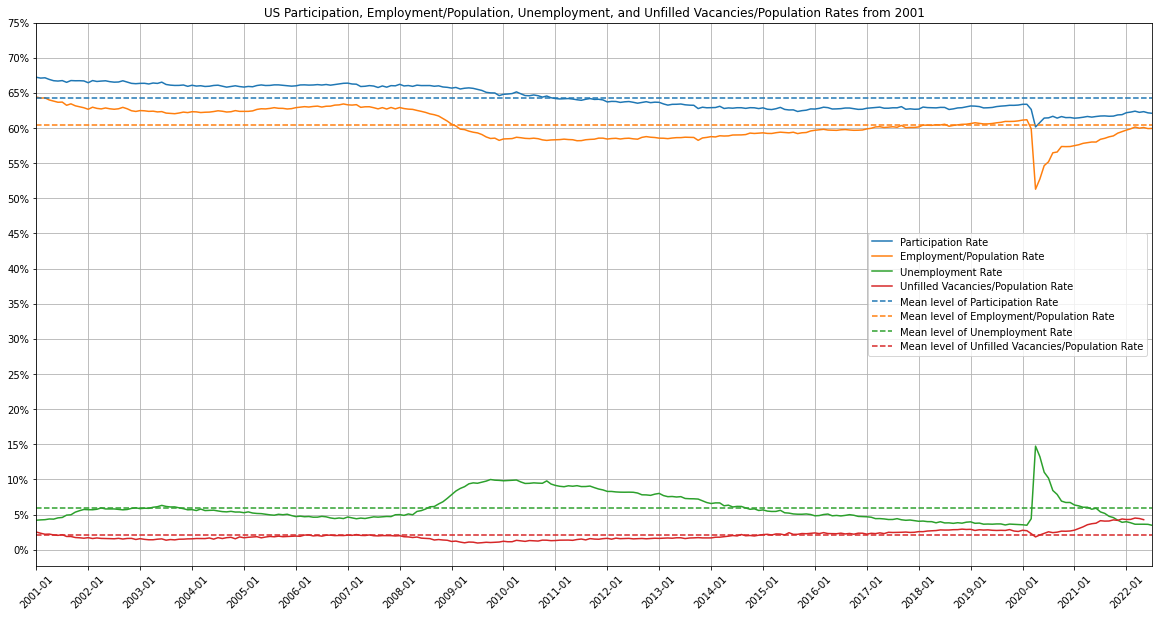

In [7]:
data_short = data.loc['2001':]
ax = data_short.iloc[:,4:].plot(figsize=(20,10), grid=True,
                                title=UNEMPLOYMENT_RATIOS_GRAPH_TITLE + ' from %d' % data_short.index[0].year,
                                xticks=data_short.index[::12], xlabel='', rot=45, yticks=np.arange(0, .8, .05))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=data_short.iloc[:,4].mean(), ls='--', c='#1f77b4', label=MEAN_PARTICIPATION_RATE)
ax.axhline(y=data_short.iloc[:,5].mean(), ls='--', c='#ff7f0e', label=MEAN_EMPLOYMENT_POPULATION_RATE)
ax.axhline(y=data_short.iloc[:,6].mean(), ls='--', c='#2ca02c', label=MEAN_UNEMPLOYMENT_RATE)
ax.axhline(y=data_short.iloc[:,7].mean(), ls='--', c='#d62728', label=MEAN_UNFILLED_VACANCIES_POPULATION_RATE)
ax.legend()
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), data_short.index[::12])))